<a href="https://colab.research.google.com/github/csabiu/KAML-2025/blob/main/KAML_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the necessary packages



In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

print(tf.__version__)

2.18.0


#Download data sample

In [2]:
!wget https://archive.kasi.re.kr/bigdata/temp/class.tar.gz
!tar zxf class.tar.gz
!rm class.tar.gz
!ls

--2025-05-10 23:35:58--  https://archive.kasi.re.kr/bigdata/temp/class.tar.gz
Resolving archive.kasi.re.kr (archive.kasi.re.kr)... 210.110.233.74
Connecting to archive.kasi.re.kr (archive.kasi.re.kr)|210.110.233.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230082147 (219M) [application/gzip]
Saving to: ‘class.tar.gz’

class.tar.gz        100%[===================>] 219.42M  2.52MB/s    in 9m 58s  

2025-05-10 23:45:58 (376 KB/s) - ‘class.tar.gz’ saved [230082147/230082147]

class  sample_data


## Lets look at an image



(424, 424, 3)


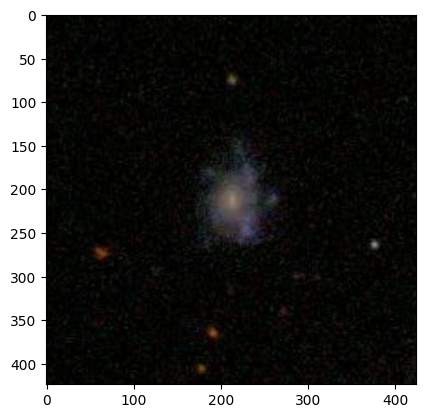

In [5]:
jpgfile = Image. open("class/100134.jpg")
plt.imshow(jpgfile)
print(np.shape(jpgfile))


# Lets crop it

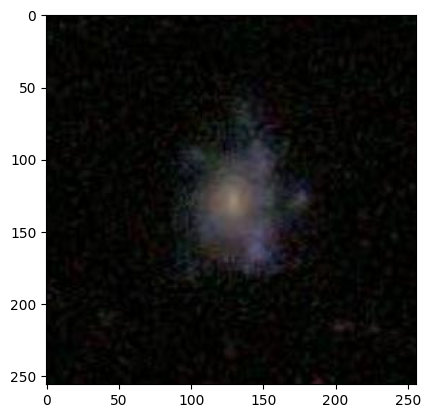

In [6]:
plt.imshow(jpgfile.crop((84,84,340,340)))

# And lower the resolution

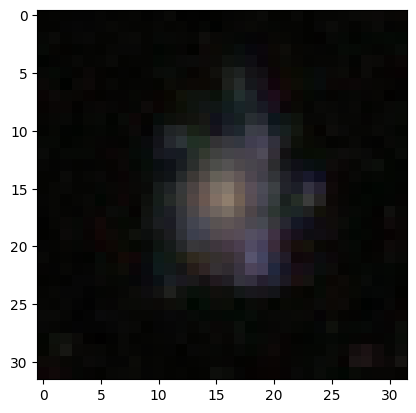

In [7]:
target_size = 32
plt.imshow(jpgfile.crop((112,112,312,312)).resize((target_size,target_size),Image.Resampling.LANCZOS))


# Split into RGB colors

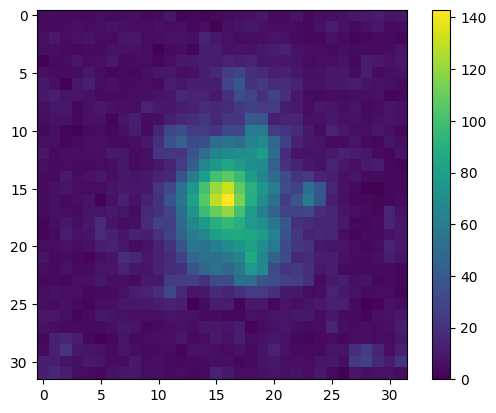

In [8]:
r,g,b=jpgfile.split()
plt.imshow(r.crop((112,112,312,312)).resize((target_size,target_size),Image.Resampling.LANCZOS))
plt.colorbar()

# Normalise the pixel values to (0,1)

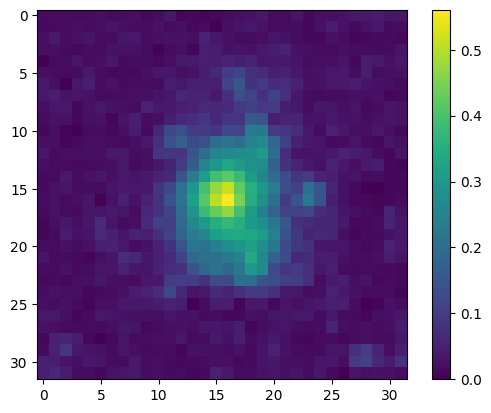

In [9]:
im=np.zeros((target_size,target_size))
im[:,:]=r.crop((112,112,312,312)).resize((target_size,target_size),Image.Resampling.LANCZOS)
im=im/255.
plt.imshow(im)
plt.colorbar()

# Load the labels (truth) data

(Image ID, galaxy type) - 0=smooth, 1=featured

In [10]:
data=np.loadtxt("class/truth.txt",dtype='i')
print(np.shape(data))
labels=data[:,1]

print(data[1:10,:]) # print first 10 entries

(16885, 2)
[[100134      1]
 [100322      1]
 [100380      1]
 [100458      0]
 [100479      0]
 [100520      1]
 [100672      0]
 [100673      1]
 [100724      0]]


<ipython-input-10-cda73ee8ae0c>:1: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  data=np.loadtxt("class/truth.txt",dtype='i')


# Lets transform all the images and save into an array

In [11]:
images=np.zeros((16885,target_size,target_size,3))
nn=0

for i in (data[:,0]):
  filename=str(int(i))+".jpg"
  jpgfile = Image. open("./class/"+filename)
  images[nn,:,:,:]=jpgfile.crop((112,112,312,312)).resize((target_size,target_size),Image.Resampling.LANCZOS)
  nn=nn+1

images=images/255.
print(np.shape(images))

# remove color - make each chanel the same by averaging
images[:,:,:,0]=np.mean(images,axis=3)
images[:,:,:,1]=images[:,:,:,0]
images[:,:,:,2]=images[:,:,:,0]
print(np.shape(images))

(16885, 32, 32, 3)
(16885, 32, 32, 3)


# Split images and labels into training and test data

In [12]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.4, random_state=42)

print(np.shape(train_data))
print(np.shape(train_label))
print(np.shape(test_data))
print(np.shape(test_label))

(10131, 32, 32, 3)
(10131,)
(6754, 32, 32, 3)
(6754,)


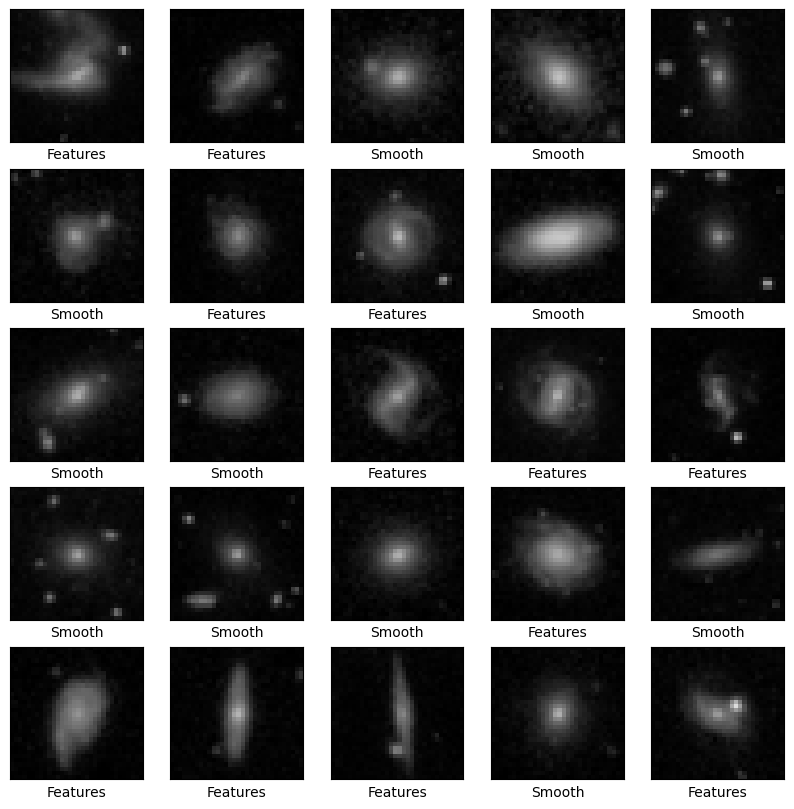

In [13]:
class_names = ['Smooth', 'Features']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(train_label[i])])
plt.show()

# Define a simple neural network

In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(target_size, target_size, 3)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)])
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,802 (768.76 KB)

 Trainable params: 196,802 (768.76 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
hist = model.fit(train_data, train_label, epochs=15, validation_split=0.2)

Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6999 - loss: 0.6012 - val_accuracy: 0.8076 - val_loss: 0.4828
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8149 - loss: 0.4555 - val_accuracy: 0.8076 - val_loss: 0.4692
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8274 - loss: 0.4217 - val_accuracy: 0.8367 - val_loss: 0.4211
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8618 - loss: 0.3714 - val_accuracy: 0.8441 - val_loss: 0.3861
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8503 - loss: 0.3694 - val_accuracy: 0.8525 - val_loss: 0.3809
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8573 - loss: 0.3568 - val_accuracy: 0.8485 - val_loss: 0.3793
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8625 - loss: 0.3447 - val_accuracy: 0.8530 - val_loss: 0.3616
Epoch 8/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8728 - loss: 0.3363 - val_accuracy: 0.

In [16]:
test_loss, test_acc = model.evaluate(test_data, test_label)
print('Test accuracy:', test_acc)

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8646 - loss: 0.3326
Test accuracy: 0.8695587515830994


Set up some of plotting functions

Text(0.5, 0, 'Epoch')

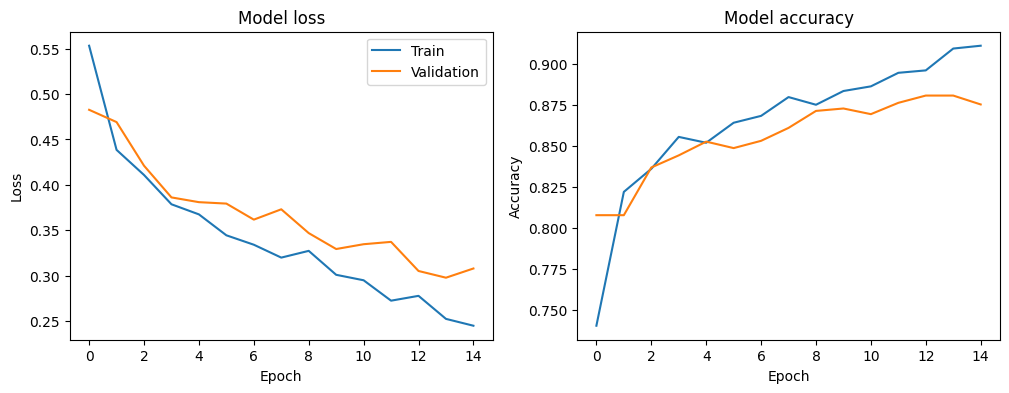

In [17]:
# plot training loss and accuracy history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [18]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[int(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([0,1])
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  #f, axarr = plt.subplots(2, sharex=True)
  #axarr[0].set_xticklabels(['smooth', 'features'])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# Make predictions on test data from the trained model

In [19]:
predictions = (model.predict(test_data[:,:,:]))

print("First 10 galaxies")
print("Predicted:",np.argmax(predictions[1:11],axis=1))
print("Truth:    ",np.int_(test_label[1:11]))

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
First 10 galaxies
Predicted: [0 0 0 0 1 0 0 1 0 1]
Truth:     [0 0 0 0 0 0 1 1 0 1]


# Lets visialise these classifications

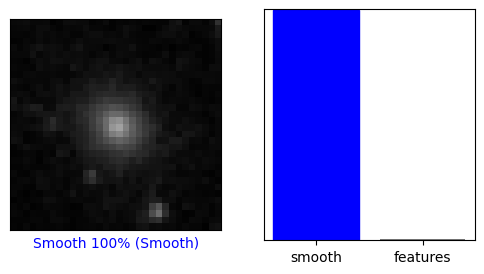

In [20]:
i = 4
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, np.int_(test_label), test_data)
f=plt.subplot(1,2,2)
plot_value_array(i, predictions,  np.int_(test_label))
f.axes.set_xticklabels(["smooth","features"])
plt.show()

 Plot the first X test images, their predicted label, and the true label
 Color correct predictions in blue, incorrect predictions in red

<ipython-input-21-d0b1e6a7fde9>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-21-d0b1e6a7fde9>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-21-d0b1e6a7fde9>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-21-d0b1e6a7fde9>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-21-d0b1e6a7fde9>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

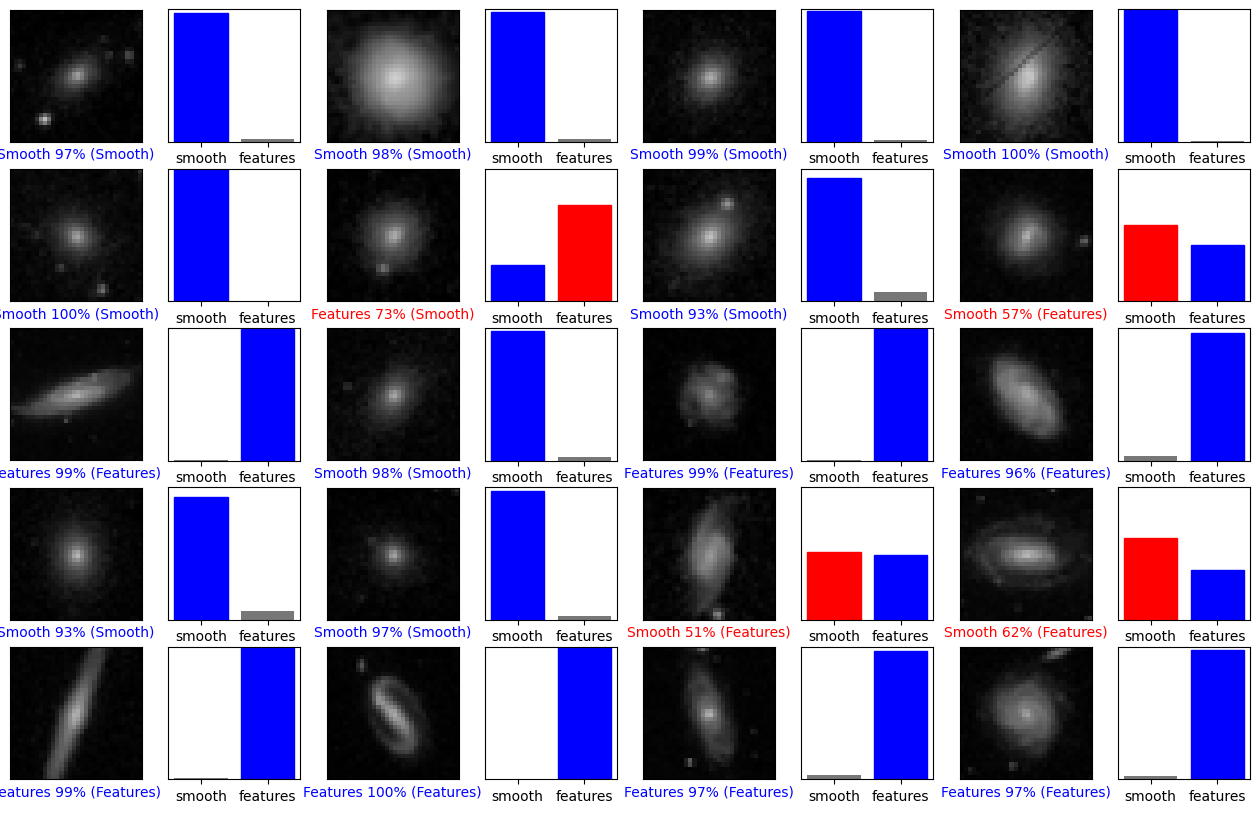

In [21]:
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()


# Define a new convolutional neural network model

In [22]:
def create_cnn_model():
  keras.backend.clear_session()
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size, target_size,3)))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Dropout(0.25))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(2, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = create_cnn_model()

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,890 (1.76 MB)

 Trainable params: 461,890 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model on the training data

In [23]:
hist = model.fit(train_data, train_label, epochs=15, validation_split=0.2)

Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7068 - loss: 0.5522 - val_accuracy: 0.8969 - val_loss: 0.2860
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8859 - loss: 0.2857 - val_accuracy: 0.9107 - val_loss: 0.2369
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8978 - loss: 0.2599 - val_accuracy: 0.9008 - val_loss: 0.2455
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9054 - loss: 0.2374 - val_accuracy: 0.9156 - val_loss: 0.2082
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9218 - loss: 0.1930 - val_accuracy: 0.9147 - val_loss: 0.2162
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9304 - loss: 0.1817 - val_accuracy: 0.9260 - val_loss: 0.1896
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9324 - loss: 0.1704 - val_accuracy: 0.9418 - val_loss: 0.1793
Epoch 8/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9446 - loss: 0.1544 - val_accuracy: 0

# Now make prediction and visualise
# Compare to previous plot

Text(0.5, 0, 'Epoch')

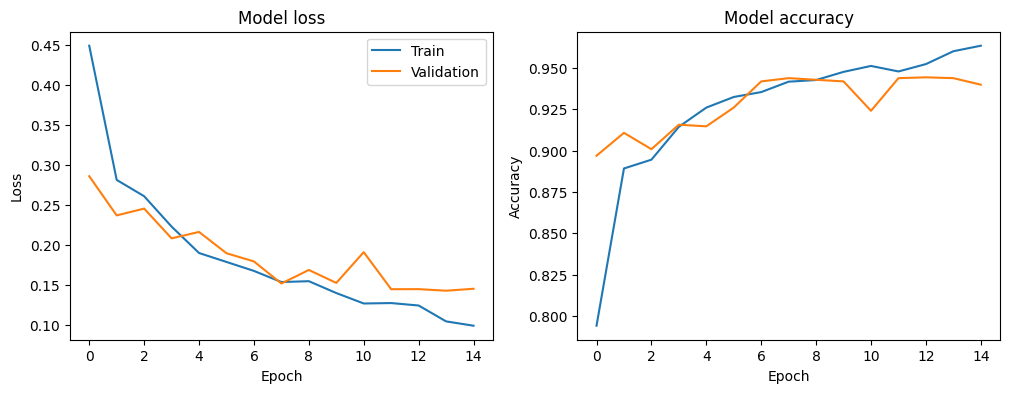

In [24]:
# plot training history again
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<ipython-input-25-e8017d881293>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-25-e8017d881293>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-25-e8017d881293>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-25-e8017d881293>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-25-e8017d881293>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

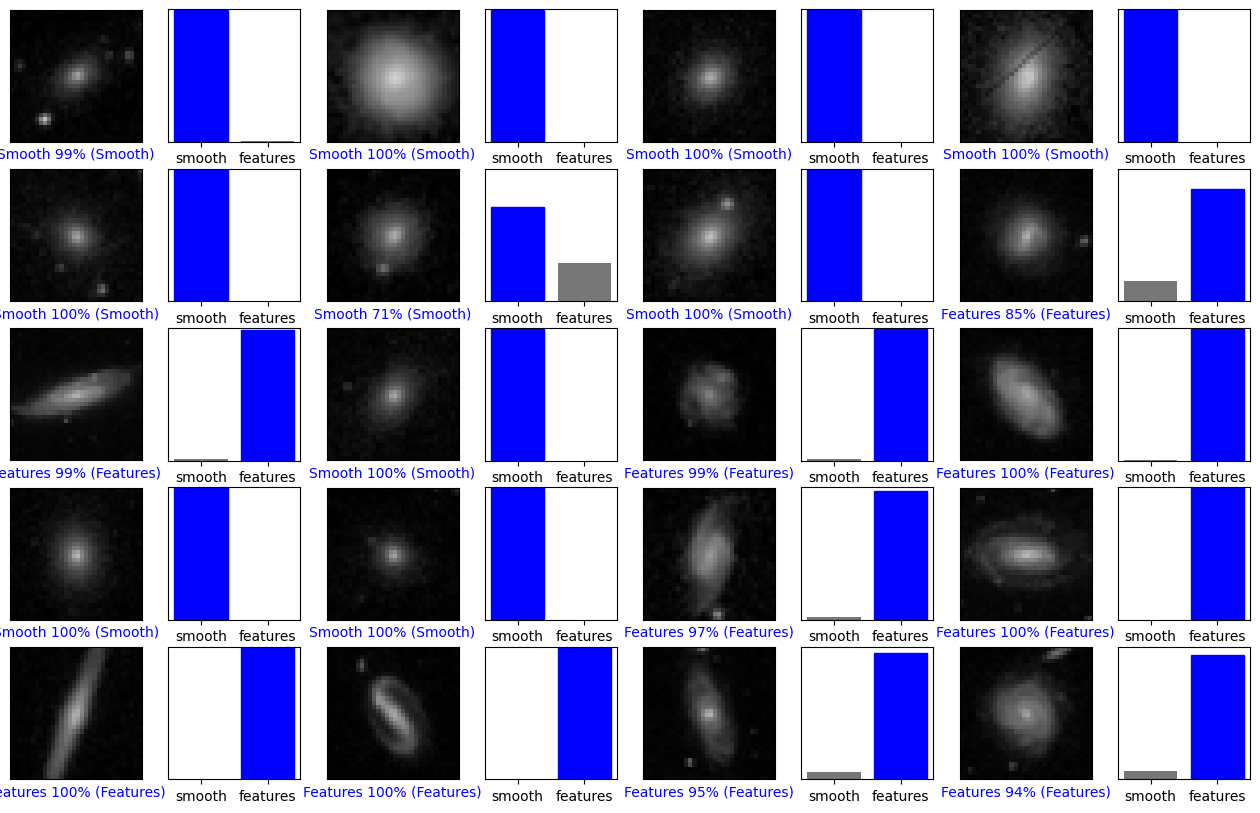

In [25]:
predictions = model.predict(test_data)

num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()

In [26]:
# compute evaluation metrics: precision and recall
from sklearn.metrics import precision_score, recall_score
print("Precision:",precision_score(np.int_(test_label),np.argmax(predictions,axis=1)))
print("Recall:",recall_score(np.int_(test_label),np.argmax(predictions,axis=1)))


Precision: 0.9545192861255037
Recall: 0.9433854907539118


# Assignment 1:
*   Create you own CNN with different number of filters and layers and final dense neural network
*   Can you improve the precision and recall values?


# Now add some data augmentations

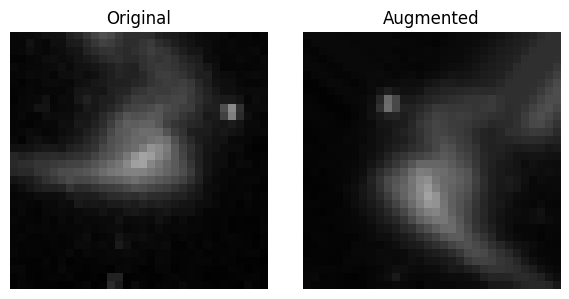

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras.preprocessing.image

# create fresh model
model = create_cnn_model()

# add data augmentation using a generator
datagen = ImageDataGenerator(width_shift_range=.2,
                             height_shift_range=.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=90,
                             fill_mode='nearest')

datagen.fit(train_data)


# -------------------------------------------------
# visualise

idx = 0
original = train_data[idx]            # shape (H, W, C), dtype float32 or uint8

iterator = datagen.flow(
    original[np.newaxis, ...],        # add batch dimension
    batch_size=1,
    shuffle=False)
augmented = next(iterator)[0]         # take the first (and only) image

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow((original))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow((augmented))
axes[1].set_title("Augmented")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [58]:
history = model.fit(datagen.flow(train_data, train_label,
                    batch_size=64),
                    epochs=15,
                    validation_data=(test_data[:100], test_label[:100])
                    )

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


159/159 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8630 - loss: 0.3331 - val_accuracy: 0.8700 - val_loss: 0.4053
Epoch 2/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8684 - loss: 0.3230 - val_accuracy: 0.8300 - val_loss: 0.4490
Epoch 3/15
131/159 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8739 - loss: 0.3058

KeyboardInterrupt: 

# Test the trained model on the test data

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_label)
print('Test accuracy:', test_acc)

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9600 - loss: 0.1168
Test accuracy: 0.9582469463348389


# Now make prediction and visualise
# Compare to previous plot

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<ipython-input-58-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-58-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-58-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-58-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-58-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

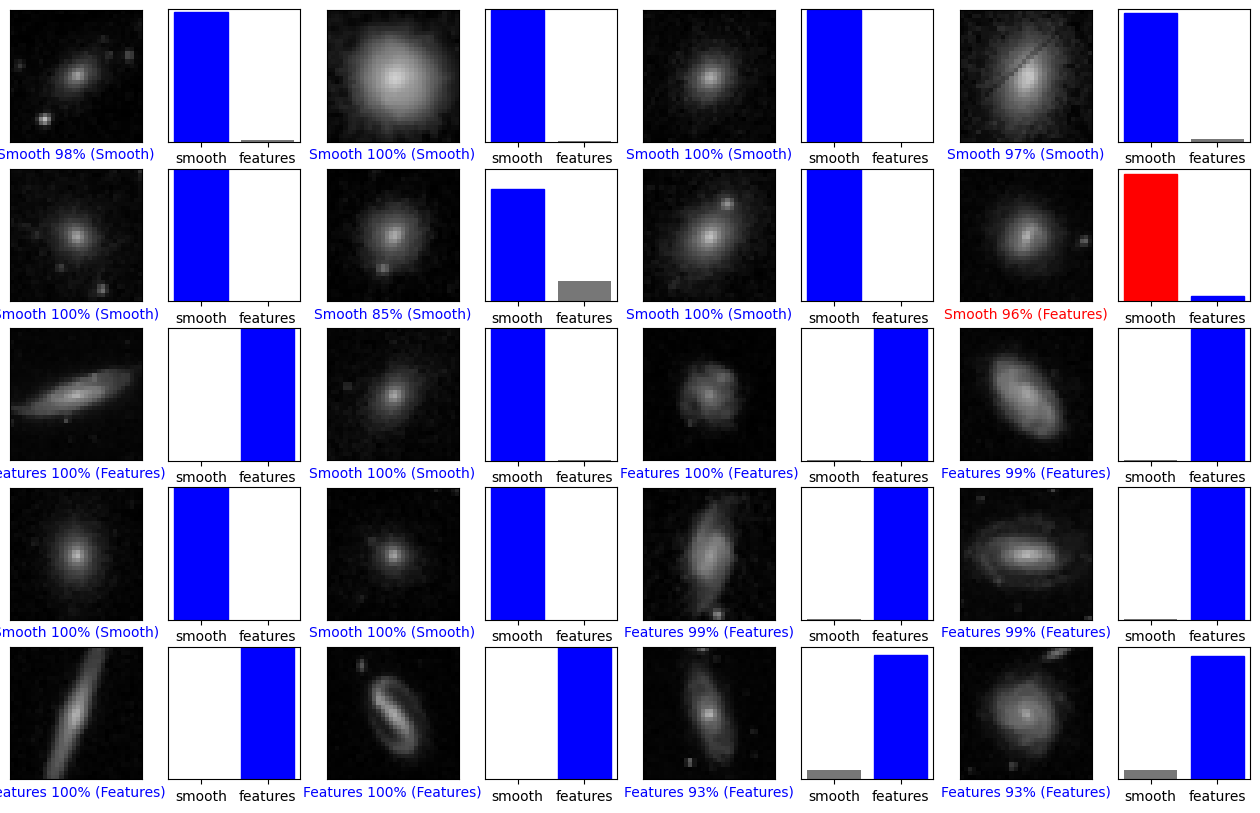

In [ ]:
predictions = (model.predict(test_data))

num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()

In [ ]:
# precision and recall
print("Precision:",precision_score(np.int_(test_label),np.argmax(predictions,axis=1)))
print("Recall:",recall_score(np.int_(test_label),np.argmax(predictions,axis=1)))

# Transfer Learning

In [30]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

# Load a pretrained network
# Load the VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(target_size, target_size, 3)))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification layer
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x) # 2 classes: smooth, featured

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,650 (56.26 MB)

 Trainable params: 32,962 (128.76 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [33]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_data, train_label, epochs=15, validation_split=0.2)

Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8286 - loss: 0.4211 - val_accuracy: 0.9364 - val_loss: 0.1796
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9240 - loss: 0.1999 - val_accuracy: 0.9290 - val_loss: 0.1749
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9379 - loss: 0.1708 - val_accuracy: 0.9526 - val_loss: 0.1257
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9419 - loss: 0.1569 - val_accuracy: 0.9541 - val_loss: 0.1257
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9422 - loss: 0.1585 - val_accuracy: 0.9561 - val_loss: 0.1175
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9451 - loss: 0.1406 - val_accuracy: 0.9581 - val_loss: 0.1084
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9482 - loss: 0.1330 - val_accuracy: 0.9581 - val_loss: 0.1177
Epoch 8/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9524 - loss: 0.1272 - val_accu

# Fine-tuning

In [35]:
# Unfreeze the top layers of the base model
for layer in base_model.layers: # Unfreeze the last 50 layers
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
# Fine-tune the model
hist2 = model.fit(train_data, train_label, epochs=10, validation_split=0.2) # Fine-tune for a few epochs

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


254/254 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9179 - loss: 0.2428 - val_accuracy: 0.9536 - val_loss: 0.1131
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.9659 - loss: 0.0923 - val_accuracy: 0.9699 - val_loss: 0.0750
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9716 - loss: 0.0763 - val_accuracy: 0.9753 - val_loss: 0.0594
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9760 - loss: 0.0657 - val_accuracy: 0.9748 - val_loss: 0.0717
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9815 - loss: 0.0546 - val_accuracy: 0.9734 - val_loss: 0.0738
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9871 - loss: 0.0386 - val_accuracy: 0.9734 - val_loss: 0.0746
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9817 - loss: 0.0465 - val_accuracy: 0.9778 - val_loss: 0.0540
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9836 - loss: 0.0434 - val_accurac

Text(0.5, 0, 'Epoch')

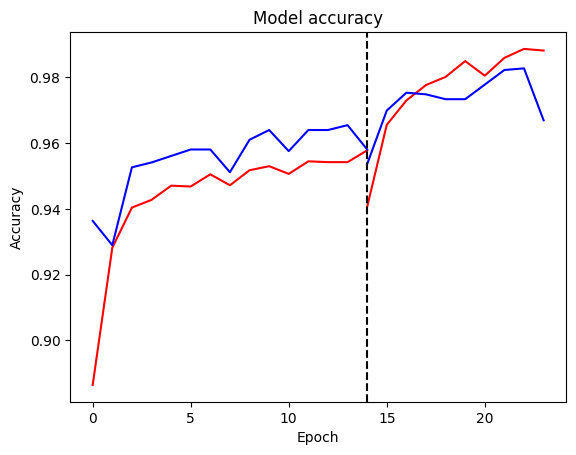

In [37]:
plt.plot(hist.history['accuracy'],'r-')
plt.plot(hist.history['val_accuracy'],'b-')
plt.plot(np.arange(14,24),hist2.history['accuracy'],'r-')
plt.plot(np.arange(14,24),hist2.history['val_accuracy'],'b-')

plt.axvline(x=14,color='k',linestyle='--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(32, 32, 32, 3))
  warnings.warn(msg)


212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


<ipython-input-38-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-38-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-38-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-38-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-38-01df32cd4b24>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

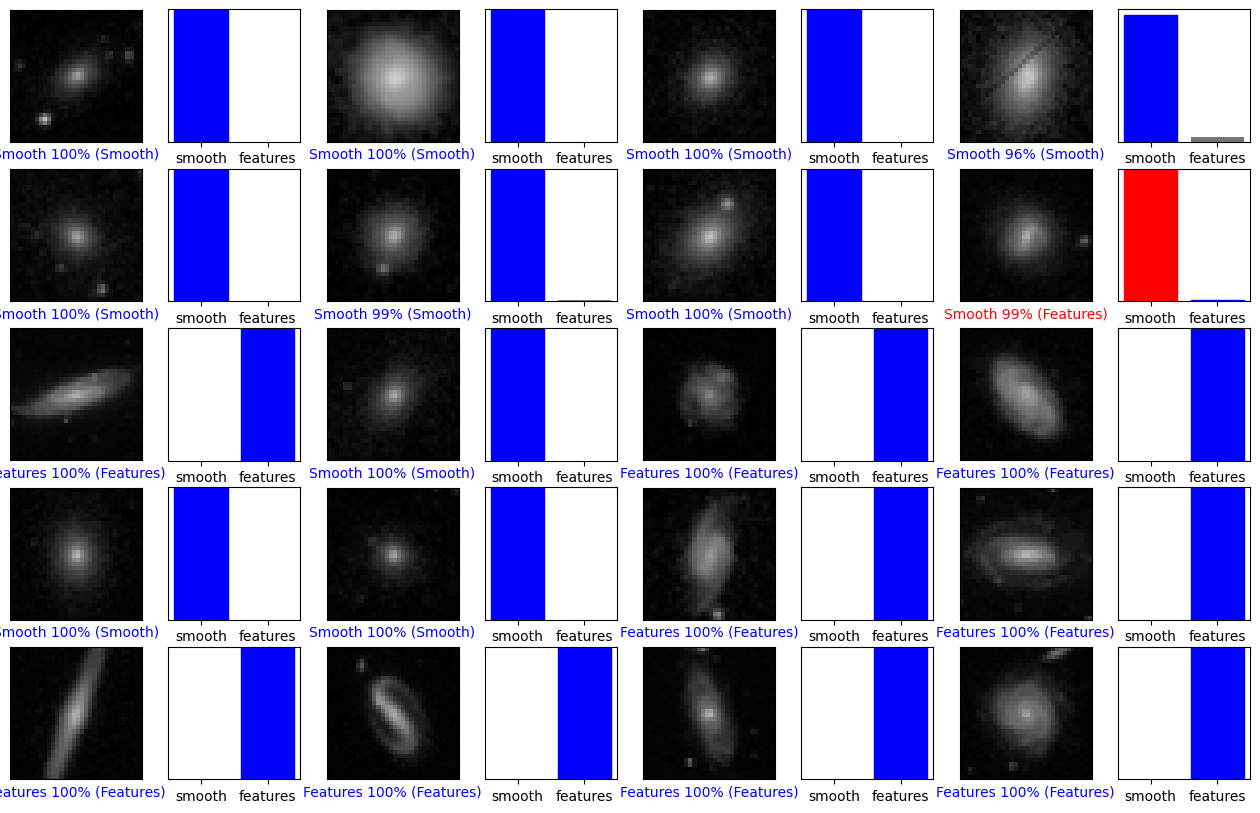

In [38]:
predictions = (model.predict(test_data))

num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_label)
print('Test accuracy:', test_acc)

212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9554 - loss: 0.1343
Test accuracy: 0.9546934962272644


In [41]:
# calculate precision and recall
print("Precision:",precision_score(np.int_(test_label),np.argmax(predictions,axis=1)))
print("Recall:",recall_score(np.int_(test_label),np.argmax(predictions,axis=1)))

Precision: 0.9948671497584541
Recall: 0.9374110953058321
